# Practice4 (test_submission1_5.csv)
> Public Score
> - test_submission1_5: 27662.58536

In [26]:
import sys, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# column 보기 30개로 설정
pd.set_option('display.max_columns', 30)

In [27]:
# 데이터 경로 설정
file_path = os.path.join(os.getcwd(), 'data')
train_origin = pd.read_csv(file_path+'\dataset.csv')
test_origin = pd.read_csv(file_path+'\problem.csv')

In [28]:
train_origin.shape, test_origin.shape

((1340, 24), (130, 23))

In [29]:
# 전처리를 위한 원본 데이터 복사
train = train_origin.copy()
test = test_origin.copy()

In [30]:
# 메모리를 효율적으로 사용하기 위한 downcast 함수 정의
def downcast(df, verbose=True):     # verbose 옵션 추가: (True)인 경우 몇 퍼센트 압축됐는지 출력
    start_mem = df.memory_usage().sum() / 1024**2   # 초기 메모리 사용량
    for col in df.columns:
        dtype_name = df[col].dtype.name
        if dtype_name == 'object':
            pass
        elif dtype_name == 'bool':
            df[col] = df[col].astype('int8')
        elif dtype_name.startswith('int') or (df[col].round() == df[col]).all():
            df[col] = pd.to_numeric(df[col], downcast='integer')
        else:
            df[col] = pd.to_numeric(df[col], downcast='float')
    end_mem = df.memory_usage().sum() / 1024**2

    if verbose:
        print(f'{(100*(start_mem - end_mem) / start_mem):.1f}% 압축됨')

    return df

In [31]:
downcast(train)
downcast(test)

67.2% 압축됨
68.7% 압축됨


Id  LotArea Street LotConfig  OverallQual  OverallCond  YearBuilt  \
0    1341    11200   Pave    Inside            5            5       1965   
1    1342     7200   Pave    Corner            5            7       1951   
2    1343    16905   Pave    Inside            5            6       1959   
3    1344     9180   Pave   CulDSac            5            7       1983   
4    1345     7200   Pave    Inside            5            7       1920   
..    ...      ...    ...       ...          ...          ...        ...   
125  1466    11478   Pave    Inside            8            5       2007   
126  1467    16321   Pave   CulDSac            5            6       1957   
127  1468     6324   Pave    Inside            4            6       1927   
128  1469     8500   Pave    Inside            4            4       1920   
129  1470     8544   Pave   CulDSac            5            6       1966   

     YearRemodAdd  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  FullBath  \
0            1965         1040      1040         0       1040         1   
1            2000          900       900         0        900         1   
2            1959         1350      1328         0       1328         1   
3            1983          840       884         0        884         1   
4            1996          530       581       530       1111         1   
..            ...          ...       ...       ...        ...       ...   
125          2008         1704      1704         0       1704         2   
126          1997         1484      1600         0       1600         1   
127          1950          520       520         0        520         1   
128          1950          649       649       668       1317         1   
129          2006         1228      1228         0       1228         1   

     HalfBath  BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  \
0           0             3             1             5           0   
1           0             3             1             5           0   
2           1             2             1             5           2   
3           0             2             1             5           0   
4           0             3             1             6           0   
..        ...           ...           ...           ...         ...   
125         0             3             1             7           1   
126         0             2             1             6           2   
127         0             1             1             4           0   
128         0             3             1             6           0   
129         1             3             1             6           0   

    GarageType  GarageYrBlt  GarageCars  GarageArea  YrSold  
0       Detchd         1965           1         384    2008  
1       Detchd         2005           2         576    2010  
2       Attchd         1959           1         308    2007  
3       Attchd         1983           2         504    2007  
4       Detchd         1935           1         288    2007  
..         ...          ...         ...         ...     ...  
125     Attchd         2008           3         772    2010  
126     Attchd         1957           1         319    2006  
127     Detchd         1920           1         240    2008  
128     Detchd         1920           1         250    2008  
129     Attchd         1966           1         271    2008  

[130 rows x 23 columns]

# 전처리

### 결측치 처리

In [32]:
train.isnull().sum()

Id               0
LotArea          0
Street           0
LotConfig        0
OverallQual      0
OverallCond      0
YearBuilt        0
YearRemodAdd     0
TotalBsmtSF      0
1stFlrSF         0
2ndFlrSF         0
GrLivArea        0
FullBath         0
HalfBath         0
BedroomAbvGr     0
KitchenAbvGr     0
TotRmsAbvGrd     0
Fireplaces       0
GarageType      81
GarageYrBlt     81
GarageCars       0
GarageArea       0
YrSold           0
SalePrice        0
dtype: int64

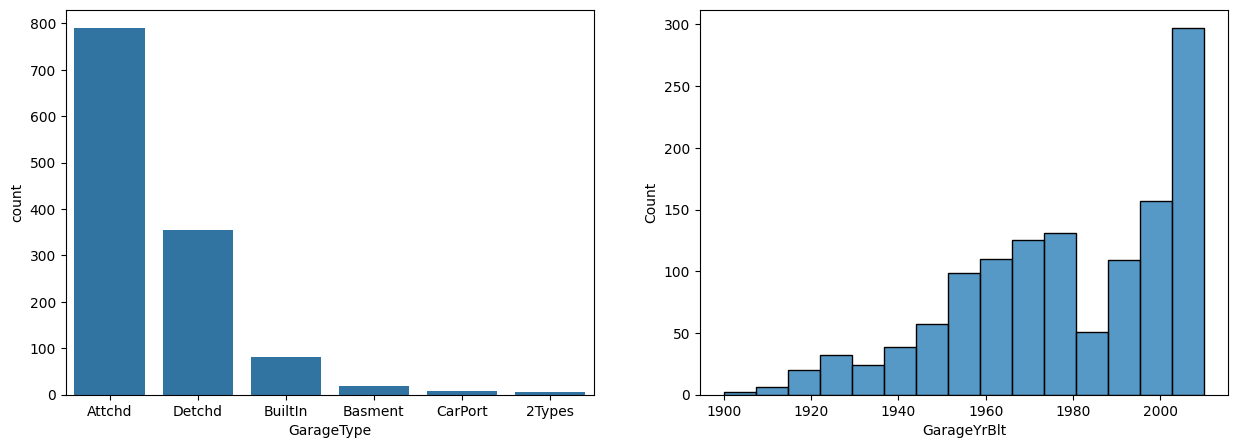

In [33]:
# 결측치 column 확인
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)    # GarageType 막대그래프
sns.barplot(train['GarageType'].value_counts())

plt.subplot(1, 2, 2)    # GarageYrBlt 히스토그램
sns.histplot(train['GarageYrBlt'])

plt.show()

In [34]:
# 최빈값 대체
train['GarageType'].fillna(train['GarageType'].mode()[0], inplace=True)
train['GarageYrBlt'].fillna(train['GarageYrBlt'].mode()[0], inplace=True)

In [35]:
train.isnull().sum().sum(), test.isnull().sum().sum()

(0, 0)

### Feature engineering

In [36]:
train['YearBuilt'].max()      # 최신에 지어진 건물 연도 확인

2010

In [37]:
# 2010년을 기준으로 건물이 지어진 후 지난 시간(연)
train['YearBuiltDiff'] = 2010 - train['YearBuilt']
test['YearBuiltDiff'] = 2010 - test['YearBuilt']

In [38]:
train['YearRemodAdd'].max()     # 리모델링 연도 확인

2010

In [39]:
# 리모델링 후 지난 시간(연)
train['RemodAddDiff'] = 2010 - train['YearRemodAdd']
test['RemodAddDiff'] = 2010 - test['YearRemodAdd']

In [40]:
# FullBath + HalfBath = TotalBath
train['TotalBath'] = train['FullBath'] + train['HalfBath']
test['TotalBath'] = test['FullBath'] + test['HalfBath']

In [41]:
# # 1stFlrSF + 2ndFlrSF = TotalFlrSF(지상층 총 평방피트) -> GrLivArea값이랑 동일
# train['TotalFlrSF'] = train['1stFlrSF'] + train['2ndFlrSF']
# test['TotalFlrSF'] = test['1stFlrSF'] + test['2ndFlrSF']

In [42]:
# 2층이 0인 경우가 꽤 많기 때문에 2층 여부 feature 추가
train['Has2ndFlr'] = train['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)
test['Has2ndFlr'] = test['2ndFlrSF'].apply(lambda x: 1 if x > 0 else 0)

In [43]:
# 지하실 여부 feature 추가
train['HasBsmt'] = train['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)
test['HasBsmt'] = test['TotalBsmtSF'].apply(lambda x: 1 if x > 0 else 0)

### 일부 feature 제거

In [46]:
no_use_features = ['Id', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'FullBath', 'HalfBath', 'YrSold', '1stFlrSF', '2ndFlrSF', 'GarageArea', 'TotRmsAbvGrd']

In [47]:
train.drop(no_use_features, axis=1, inplace=True)
test.drop(no_use_features, axis=1, inplace=True)

### 중복 데이터 제거

In [48]:
train.duplicated().sum()    # 중복 데이터 확인

2

In [49]:
train = train.drop_duplicates()     # 중복 데이터 제거

### 이상치 처리
> target 값인 SalePrice와 그와 상관관계가 매우 높은 몇 가지 feature만 이상치 처리를 좀 해주자.

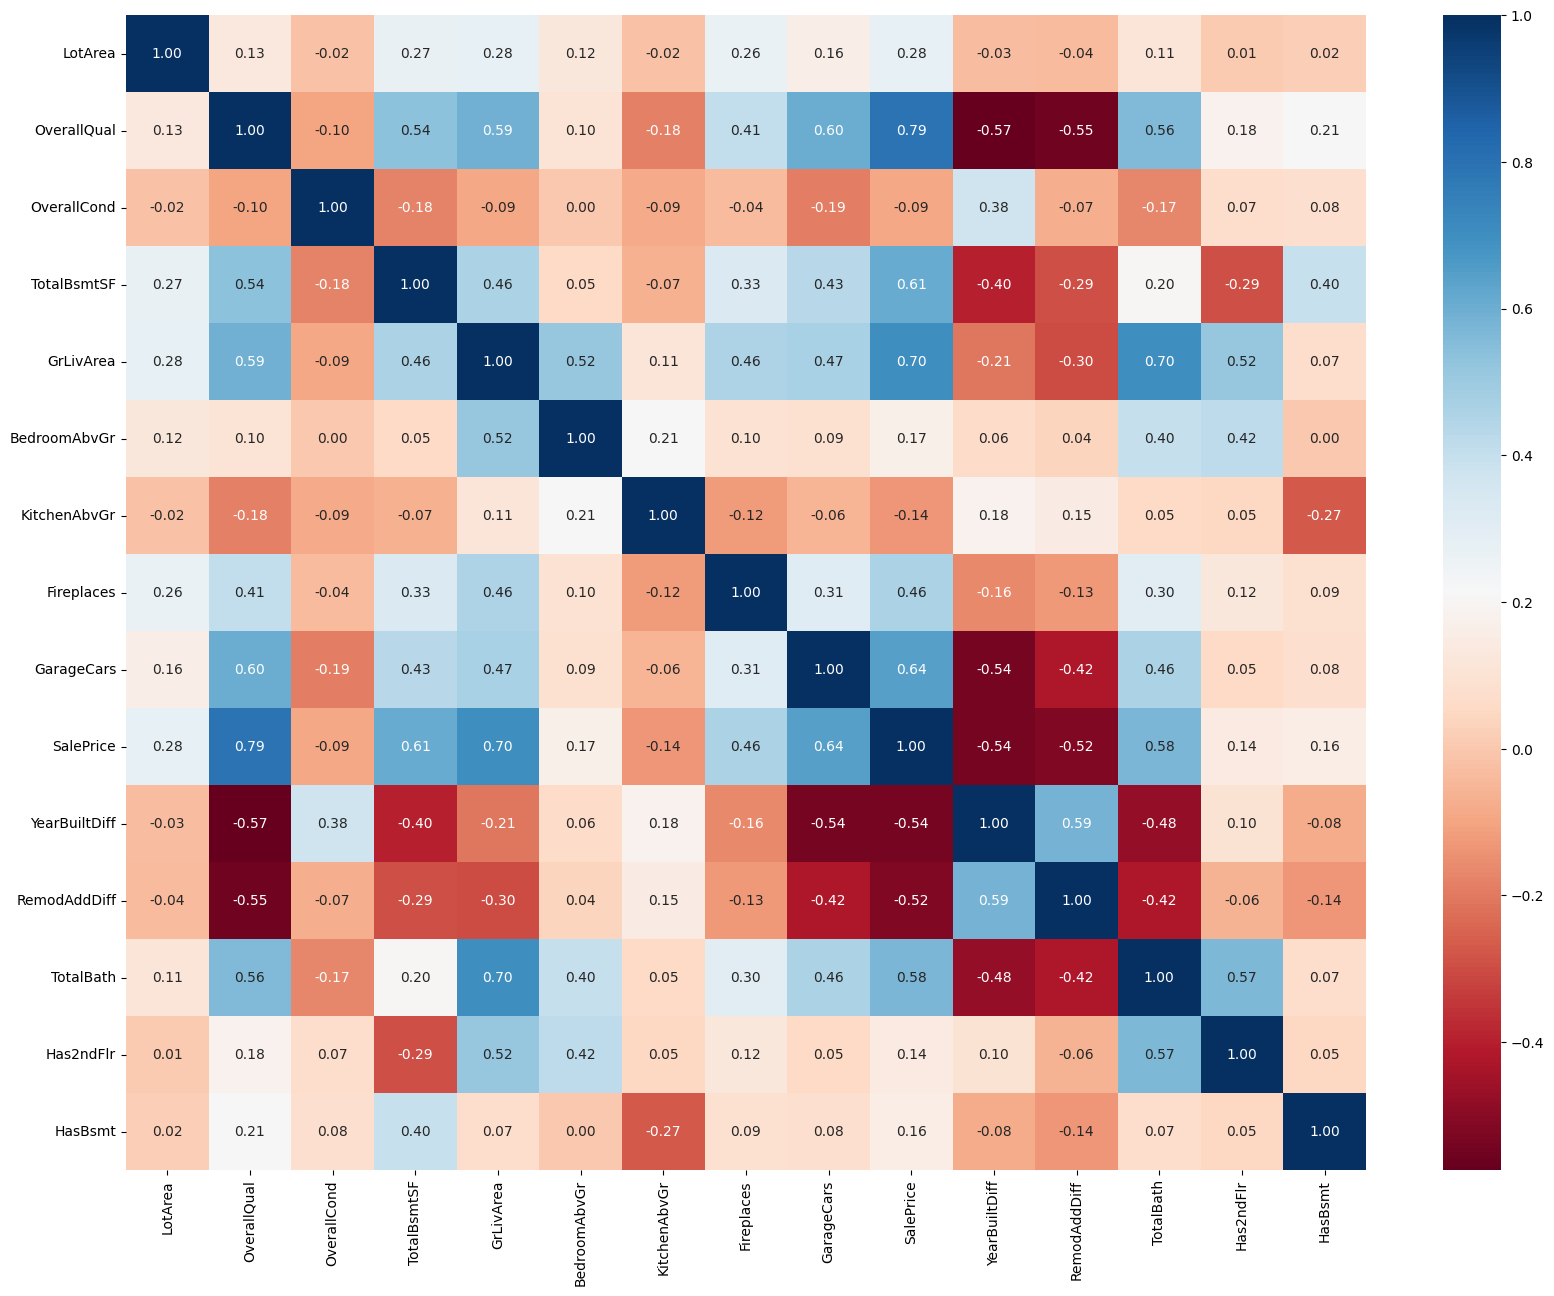

In [50]:
# 상관계수 히트맵
numeric_data = train.select_dtypes(exclude="object")   # 수치형 데이터만 추출
plt.figure(figsize=(20, 15))
sns.heatmap(numeric_data.corr(), annot=True, fmt='.2f', cmap='RdBu')    # 절반만 표시하고 싶은 경우 mask=mask 옵션 추가
plt.show()

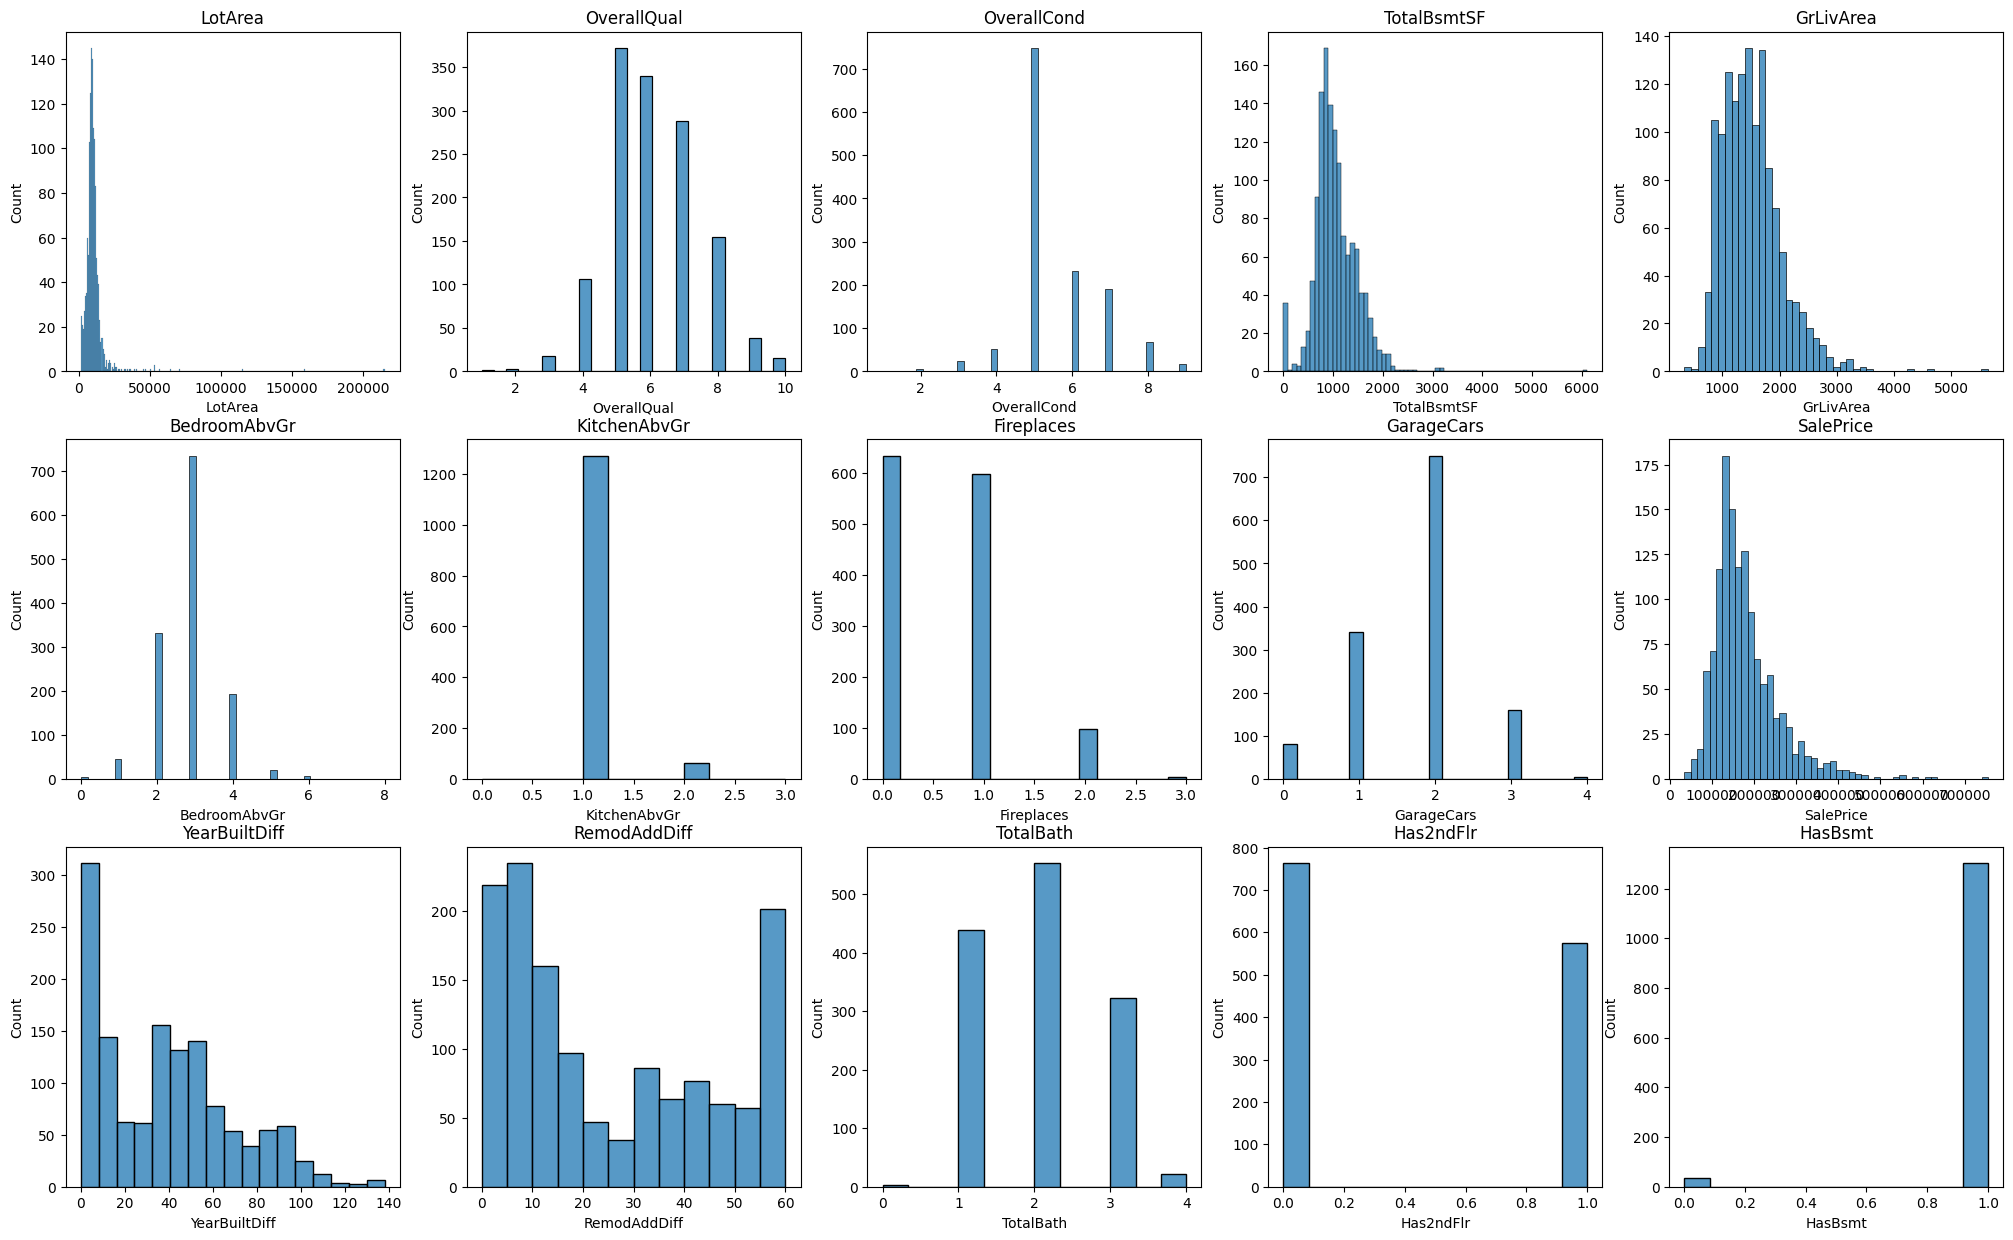

In [51]:
# 모든 수치형 변수의 히스토그램 한 번에 시각화
plt.figure(figsize=(25, 15))
for i, col in enumerate(numeric_data.columns):
    plt.subplot(3, 5, i+1)
    sns.histplot(train[col], kde=False)
    plt.title(col)

> GrLivArea

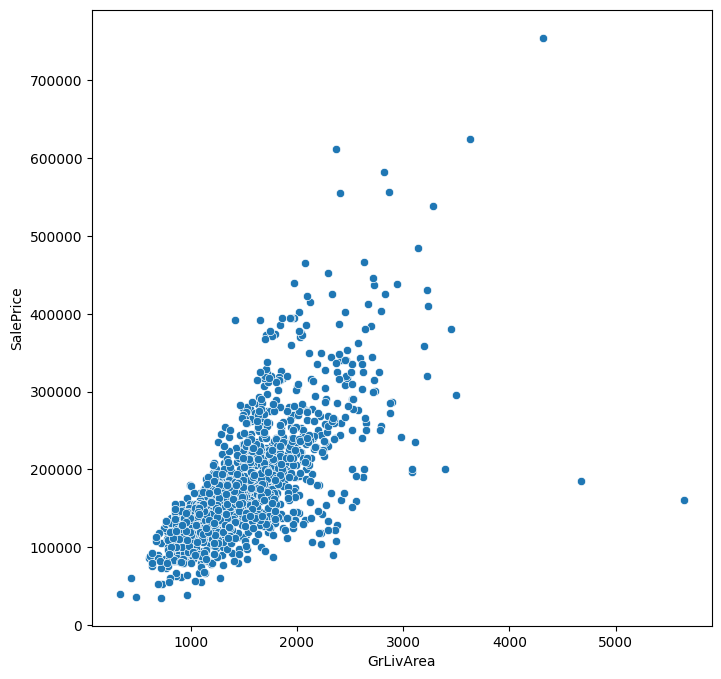

In [52]:
# GrLivArea와 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')
plt.show()

In [53]:
# 이상치 제거
outlier_index = train[(train['SalePrice']<220000)&(train['GrLivArea']>4000)]
train = train.drop(outlier_index.index).reset_index(drop=True)

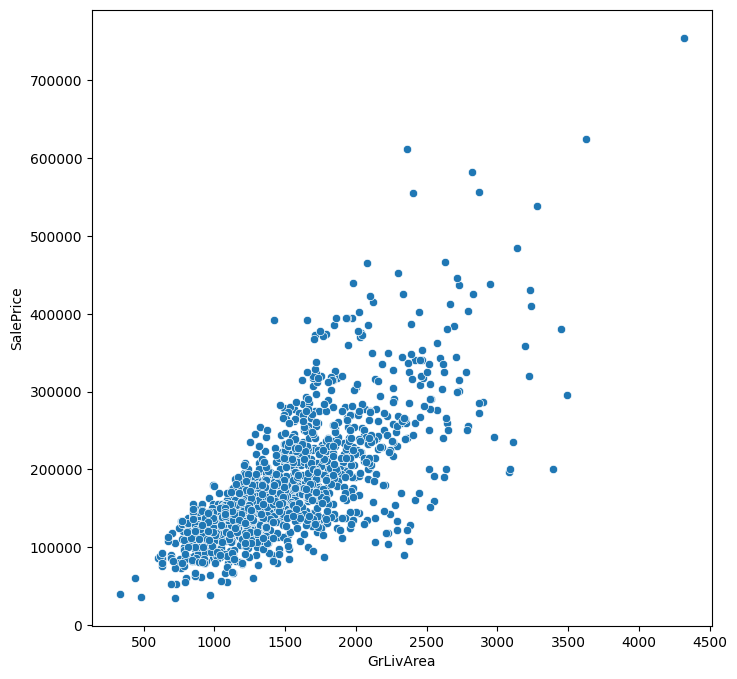

In [327]:
# GrLivArea와 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='GrLivArea', y='SalePrice')
plt.show()

> TotalBsmtSF

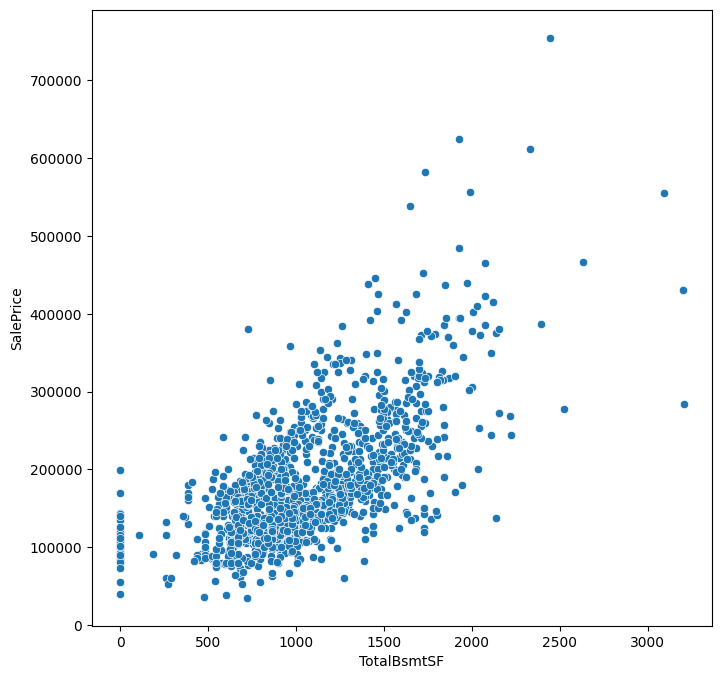

In [328]:
# OverallQual과 SalePrice scatterplot
plt.figure(figsize=(8, 8))
sns.scatterplot(data=train, x='TotalBsmtSF', y='SalePrice')
plt.show()

### 수치형 변수들 편향도 확인

In [54]:
numeric_cat = ['LotArea', 'TotalBsmtSF', 'GrLivArea', 'SalePrice']

for i in numeric_cat:
    skewed_value = train[i].skew()
    print(f'{i}의 왜도: {skewed_value:.2f}')

    log_value = np.log1p(train[i])
    print(f'로그 변환 후 {i}의 왜도: {log_value.skew():.2f}')

LotArea의 왜도: 13.14
로그 변환 후 LotArea의 왜도: -0.24
TotalBsmtSF의 왜도: 0.52
로그 변환 후 TotalBsmtSF의 왜도: -5.04
GrLivArea의 왜도: 0.92
로그 변환 후 GrLivArea의 왜도: -0.08
SalePrice의 왜도: 1.78
로그 변환 후 SalePrice의 왜도: 0.14


> LotArea와 SalePrice의 왜도가 높은 편이니 log변환을 해보자

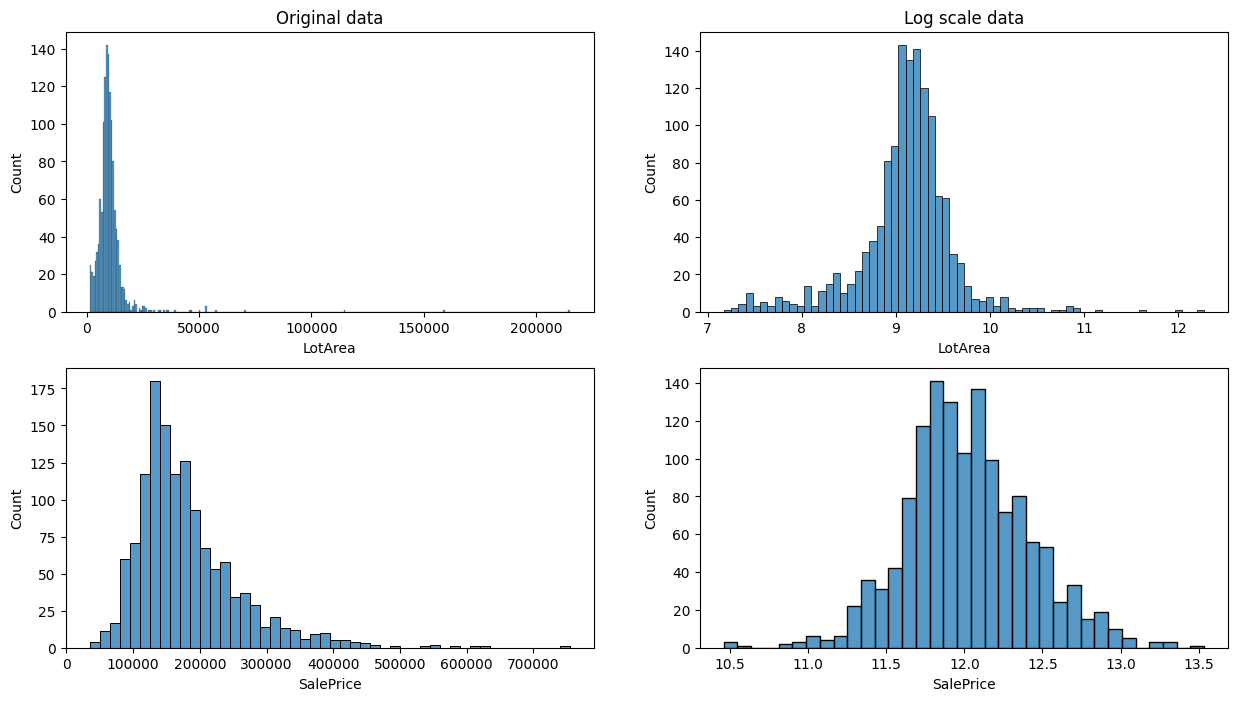

In [330]:
plt.figure(figsize=(15, 8))

plt.subplot(2, 2, 1)
plt.title('Original data')
sns.histplot(train['LotArea'])

plt.subplot(2, 2, 2)
plt.title('Log scale data')
sns.histplot(np.log1p(train['LotArea']))

plt.subplot(2, 2, 3)
sns.histplot(train['SalePrice'])

plt.subplot(2, 2, 4)
sns.histplot(np.log1p(train['SalePrice']))

plt.show()

In [55]:
train['LotArea'] = np.log1p(train['LotArea'])
test['LotArea'] = np.log1p(test['LotArea'])

train['SalePrice'] = np.log1p(train['SalePrice'])

### Encoding

In [56]:
# X, y 분리
X_train = train.drop(columns='SalePrice', axis=1)
y_train = train['SalePrice']

In [57]:
all_data = pd.concat([X_train, test], axis=0).reset_index(drop=True)

In [58]:
all_data

LotArea Street LotConfig  OverallQual  OverallCond  TotalBsmtSF  \
0     9.042040   Pave    Inside            7            5          856   
1     9.169623   Pave       FR2            6            8         1262   
2     9.328212   Pave    Inside            7            5          920   
3     9.164401   Pave    Corner            7            5          756   
4     9.565284   Pave       FR2            8            5         1145   
...        ...    ...       ...          ...          ...          ...   
1461  9.348275   Pave    Inside            8            5         1704   
1462  9.700269   Pave   CulDSac            5            6         1484   
1463  8.752265   Pave    Inside            4            6          520   
1464  9.047939   Pave    Inside            4            4          649   
1465  9.053102   Pave   CulDSac            5            6         1228   

      GrLivArea  BedroomAbvGr  KitchenAbvGr  Fireplaces GarageType  \
0          1710             3             1           0     Attchd   
1          1262             3             1           1     Attchd   
2          1786             3             1           1     Attchd   
3          1717             3             1           1     Detchd   
4          2198             4             1           1     Attchd   
...         ...           ...           ...         ...        ...   
1461       1704             3             1           1     Attchd   
1462       1600             2             1           2     Attchd   
1463        520             1             1           0     Detchd   
1464       1317             3             1           0     Detchd   
1465       1228             3             1           0     Attchd   

      GarageCars  YearBuiltDiff  RemodAddDiff  TotalBath  Has2ndFlr  HasBsmt  
0              2              7             7          3          1        1  
1              2             34            34          2          0        1  
2              2              9             8          3          1        1  
3              3             95            40          1          1        1  
4              3             10            10          3          1        1  
...          ...            ...           ...        ...        ...      ...  
1461           3              3             2          2          0        1  
1462           1             53            13          1          0        1  
1463           1             83            60          1          0        1  
1464           1             90            60          1          1        1  
1465           1             44             4          2          0        1  

[1466 rows x 17 columns]

In [335]:
# # 일부 column들은 숫자형이지만 실제로는 범주형 변수이므로 object로 변환
# object_cat = ['OverallQual', 'OverallCond', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'YearBuiltDiff', 'RemodAddDiff', 'TotalBath', 'Has2ndFlr']

# for i in object_cat:
#     all_data[i] = all_data[i].astype('object')

In [59]:
# 일부 category는 OHE
OHE_cat = ['Street', 'LotConfig', 'GarageType']

all_data = pd.get_dummies(all_data, columns=OHE_cat)

In [60]:
all_data

LotArea  OverallQual  OverallCond  TotalBsmtSF  GrLivArea  \
0     9.042040            7            5          856       1710   
1     9.169623            6            8         1262       1262   
2     9.328212            7            5          920       1786   
3     9.164401            7            5          756       1717   
4     9.565284            8            5         1145       2198   
...        ...          ...          ...          ...        ...   
1461  9.348275            8            5         1704       1704   
1462  9.700269            5            6         1484       1600   
1463  8.752265            4            6          520        520   
1464  9.047939            4            4          649       1317   
1465  9.053102            5            6         1228       1228   

      BedroomAbvGr  KitchenAbvGr  Fireplaces  GarageCars  YearBuiltDiff  \
0                3             1           0           2              7   
1                3             1           1           2             34   
2                3             1           1           2              9   
3                3             1           1           3             95   
4                4             1           1           3             10   
...            ...           ...         ...         ...            ...   
1461             3             1           1           3              3   
1462             2             1           2           1             53   
1463             1             1           0           1             83   
1464             3             1           0           1             90   
1465             3             1           0           1             44   

      RemodAddDiff  TotalBath  Has2ndFlr  HasBsmt  Street_Grvl  Street_Pave  \
0                7          3          1        1        False         True   
1               34          2          0        1        False         True   
2                8          3          1        1        False         True   
3               40          1          1        1        False         True   
4               10          3          1        1        False         True   
...            ...        ...        ...      ...          ...          ...   
1461             2          2          0        1        False         True   
1462            13          1          0        1        False         True   
1463            60          1          0        1        False         True   
1464            60          1          1        1        False         True   
1465             4          2          0        1        False         True   

      LotConfig_Corner  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  \
0                False              False          False          False   
1                False              False           True          False   
2                False              False          False          False   
3                 True              False          False          False   
4                False              False           True          False   
...                ...                ...            ...            ...   
1461             False              False          False          False   
1462             False               True          False          False   
1463             False              False          False          False   
1464             False              False          False          False   
1465             False               True          False          False   

      LotConfig_Inside  GarageType_2Types  GarageType_Attchd  \
0                 True              False               True   
1                False              False               True   
2                 True              False               True   
3                False              False              False   
4                False              False               True   
...                ...                ...              

In [61]:
# 공통 전처리 끝
X_train = all_data.iloc[:len(X_train)]
test = all_data.iloc[len(X_train):].reset_index(drop=True)

In [62]:
X_train.shape, test.shape

((1336, 27), (130, 27))

In [63]:
# 수치형 변수들 Robust Scaling
from sklearn.preprocessing import RobustScaler

cols = ['LotArea', 'TotalBsmtSF', 'GrLivArea']

scaler = RobustScaler().fit(X_train[cols])

X_train.loc[:, cols] = scaler.transform(X_train[cols])
test.loc[:, cols] = scaler.transform(test[cols])

In [64]:
X_train

LotArea  OverallQual  OverallCond  TotalBsmtSF  GrLivArea  \
0    -0.263609            7            5    -0.258717   0.389272   
1     0.034719            6            8     0.561900  -0.297318   
2     0.405552            7            5    -0.129358   0.505747   
3     0.022510            7            5    -0.460839   0.400000   
4     0.959900            8            5     0.325417   1.137165   
...        ...          ...          ...          ...        ...   
1331 -0.415941            6            5    -0.062658   0.292720   
1332  0.774865            6            6     1.127842   0.945594   
1333 -0.105291            7            9     0.339565   1.354789   
1334  0.063042            5            6     0.189995  -0.579310   
1335  0.115388            5            6     0.549773  -0.306513   

      BedroomAbvGr  KitchenAbvGr  Fireplaces  GarageCars  YearBuiltDiff  \
0                3             1           0           2              7   
1                3             1           1           2             34   
2                3             1           1           2              9   
3                3             1           1           3             95   
4                4             1           1           3             10   
...            ...           ...         ...         ...            ...   
1331             3             1           1           2             11   
1332             3             1           2           2             32   
1333             4             1           2           1             69   
1334             2             1           0           1             60   
1335             3             1           0           1             45   

      RemodAddDiff  TotalBath  Has2ndFlr  HasBsmt  Street_Grvl  Street_Pave  \
0                7          3          1        1        False         True   
1               34          2          0        1        False         True   
2                8          3          1        1        False         True   
3               40          1          1        1        False         True   
4               10          3          1        1        False         True   
...            ...        ...        ...      ...          ...          ...   
1331            10          3          1        1        False         True   
1332            22          2          0        1        False         True   
1333             4          2          1        1        False         True   
1334            14          1          0        1        False         True   
1335            45          2          0        1        False         True   

      LotConfig_Corner  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  \
0                False              False          False          False   
1                False              False           True          False   
2                False              False          False          False   
3                 True              False          False          False   
4                False              False           True          False   
...                ...                ...            ...            ...   
1331             False              False          False          False   
1332             False              False          False          False   
1333             False              False          False          False   
1334             False              False          False          False   
1335             False              False          False          False   

      LotConfig_Inside  GarageType_2Types  GarageType_Attchd  \
0                 True              False               True   
1                False              False               True   
2                 True              False               True   
3                False              False              False   
4                False              False               True   
...                ...                ...              

In [65]:
test

LotArea  OverallQual  OverallCond  TotalBsmtSF  GrLivArea  BedroomAbvGr  \
0    0.395137            5            5     0.113188  -0.637548             3   
1   -0.637891            5            7    -0.169783  -0.852107             3   
2    1.357741            5            6     0.739768  -0.196169             2   
3   -0.069876            5            7    -0.291056  -0.876628             2   
4   -0.637891            5            7    -0.917635  -0.528736             3   
..        ...          ...          ...          ...        ...           ...   
125  0.452464            8            5     1.455280   0.380077             3   
126  1.275538            5            6     1.010611   0.220690             2   
127 -0.941194            4            6    -0.937847  -1.434483             1   
128 -0.249815            4            4    -0.677110  -0.213027             3   
129 -0.237744            5            6     0.493178  -0.349425             3   

     KitchenAbvGr  Fireplaces  GarageCars  YearBuiltDiff  RemodAddDiff  \
0               1           0           1             45            45   
1               1           0           2             59            10   
2               1           2           1             51            51   
3               1           0           2             27            27   
4               1           0           1             90            14   
..            ...         ...         ...            ...           ...   
125             1           1           3              3             2   
126             1           2           1             53            13   
127             1           0           1             83            60   
128             1           0           1             90            60   
129             1           0           1             44             4   

     TotalBath  Has2ndFlr  HasBsmt  Street_Grvl  Street_Pave  \
0            1          0        1        False         True   
1            1          0        1        False         True   
2            2          0        1        False         True   
3            1          0        1        False         True   
4            1          1        1        False         True   
..         ...        ...      ...          ...          ...   
125          2          0        1        False         True   
126          1          0        1        False         True   
127          1          0        1        False         True   
128          1          1        1        False         True   
129          2          0        1        False         True   

     LotConfig_Corner  LotConfig_CulDSac  LotConfig_FR2  LotConfig_FR3  \
0               False              False          False          False   
1                True              False          False          False   
2               False              False          False          False   
3               False               True          False          False   
4               False              False          False          False   
..                ...                ...            ...            ...   
125             False              False          False          False   
126             False               True          False          False   
127             False              False          False          False   
128             False              False          False          False   
129             False               True          False          False   

     LotConfig_Inside  GarageType_2Types  GarageType_Attchd  \
0                True              False              False   
1               False              False              False   
2                True              False               True   
3               False              False               True   
4                True              False              False   
..                ...                ...                ...   
125              True              False     

# Model training

In [211]:
# # target을 log 변환하지 않은 경우의 metric
# def RMSE(y_pred, y_true):
#     return -np.sqrt(np.mean(np.square(y_pred - y_true)))

# target을 log 변환한 경우의 metric
def RMSE_expm1(y_pred, y_true):
    return -np.sqrt(np.mean(np.square(np.expm1(y_pred) - np.expm1(y_true))))

In [ ]:
def RMSE_expm1(y_pred, y_true):
    return np.sqrt(np.mean(np.square(np.expm1(y_pred) - np.expm1(y_true))))

kf = KFold(n_splits=10, shuffle=True, random_state=42)

scores = []
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    xgb_model = XGBRegressor(**params, random_state=42)
    xgb_model.fit(X_train_fold, y_train_fold)
    y_pred = xgb_model.predict(X_val_fold)
    scores.append(RMSE_expm1(y_pred, y_val_fold))

return -np.mean(scores)

### XGBoost

In [67]:
# 베이지안 최적화
from sklearn.model_selection import KFold
from xgboost import XGBRegressor

def RMSE_expm1(y_pred, y_true):
    return np.sqrt(np.mean(np.square(np.expm1(y_pred) - np.expm1(y_true))))

param_bounds = {
    'learning_rate' : (0.001, 0.5),
    'max_leaves': (2, 1024),
    'n_estimators': (100, 1000),
    'gamma': (0, 10),
    'max_depth': (3, 15),
    'min_child_weight': (1, 10),
    }

def eval_function(max_leaves, learning_rate, n_estimators, gamma, max_depth, min_child_weight):
    params = {
        'learning_rate' : learning_rate, 
        'max_leaves': int(max_leaves),
        'n_estimators': int(n_estimators),
        'gamma': gamma,
        'max_depth': int(max_depth),
        'min_child_weight': min_child_weight,
    }


    kf = KFold(n_splits=10, shuffle=True, random_state=42)

    scores = []
    for train_index, test_index in kf.split(X_train):
        X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        xgb_model = XGBRegressor(**params, random_state=42)
        xgb_model.fit(X_train_fold, y_train_fold)
        y_pred = xgb_model.predict(X_val_fold)
        scores.append(RMSE_expm1(y_pred, y_val_fold))

    return -np.mean(scores)

In [68]:
from bayes_opt import BayesianOptimization

optimizer = BayesianOptimization(f=eval_function, pbounds=param_bounds, random_state=42)
optimizer.maximize(init_points=5, n_iter=50)

|   iter    |  target   |   gamma   | learni... | max_depth | max_le... | min_ch... | n_esti... |
-------------------------------------------------------------------------------------------------
| 1         | -3.924e+0 | 3.745     | 0.4754    | 11.78     | 613.8     | 2.404     | 240.4     |
| 2         | -3.047e+0 | 0.5808    | 0.4332    | 10.21     | 725.7     | 1.185     | 972.9     |
| 3         | -4.732e+0 | 8.324     | 0.107     | 5.182     | 189.4     | 3.738     | 572.3     |
| 4         | -4.065e+0 | 4.319     | 0.1463    | 10.34     | 144.6     | 3.629     | 429.7     |
| 5         | -4.017e+0 | 4.561     | 0.3928    | 5.396     | 527.5     | 6.332     | 141.8     |
| 6         | -2.819e+0 | 0.1771    | 0.5       | 13.2      | 868.1     | 1.634     | 1e+03     |
| 7         | -4.113e+0 | 5.241     | 0.4091    | 10.74     | 867.8     | 7.77      | 999.8     |
| 8         | -3.599e+0 | 2.104     | 0.4963    | 5.567     | 718.5     | 5.461     | 358.9     |
| 9         | -4.576

In [69]:
# 최적화된 하이퍼파라미터로 모델 재학습
best_params = {
    'n_estimators': round(optimizer.max['params']['n_estimators']),
    'max_depth': round(optimizer.max['params']['max_depth']),
    'max_leaves': round(optimizer.max['params']['max_leaves']),
    'min_child_weight': round(optimizer.max['params']['min_child_weight']),
    'learning_rate': optimizer.max['params']['learning_rate'],
    'gamma': optimizer.max['params']['gamma'],
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)

scores = []
for train_index, test_index in kf.split(X_train):
    X_train_fold, X_val_fold = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

    best_xgb = XGBRegressor(**best_params, random_state=42)
    best_xgb.fit(X_train_fold, y_train_fold)
    y_pred = best_xgb.predict(X_val_fold)
    scores.append(RMSE_expm1(y_pred, y_val_fold))

print(scores)
print(np.mean(scores))

[21089.586513626902, 25498.72835562132, 20947.021628799735, 30810.136920996138, 24397.46050675038, 20747.342411031663, 26628.57516226707, 34953.15192925297, 26938.26901954182, 26498.493438591566]
25850.87658864796


In [70]:
# 모델의 결정계수 확인
from sklearn.metrics import r2_score

best_xgb = XGBRegressor(**best_params, random_state=42)
best_xgb.fit(X_train, y_train)
y_pred = best_xgb.predict(X_train)

r2_score(y_pred, y_train)

0.9995076406680758

In [71]:
origin_y = np.expm1(y_train)
origin_pred = np.expm1(y_pred)
r2_score(origin_y, origin_pred)

0.9996124594903852

In [72]:
# RMSE
from sklearn.metrics import mean_squared_error

np.sqrt(mean_squared_error(origin_y, origin_pred))

1539.994174930093

### LightGBM

In [96]:
# 베이지안 최적화
from sklearn.model_selection import cross_val_score
from lightgbm import LGBMRegressor

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train_scaled, y_train, scoring='neg_mean_squared_error', cv=10))
    return rmse, rmse.mean()

param_bounds = {
    'n_estimators': (100, 1000),
    'max_depth': (3, 15),
    'num_leaves': (20, 300),
    'min_child_samples': (10, 30),
    'learning_rate': (0.001, 0.5),
}

def eval_function(n_estimators, max_depth, num_leaves, min_child_samples, learning_rate):
    params = {
        'n_estimators': int(n_estimators),
        'max_depth': int(max_depth),
        'num_leaves': int(num_leaves),
        'min_child_samples': int(min_child_samples),
        'learning_rate': learning_rate,
    }

    lgbm = LGBMRegressor(**params, metric='RMSE', random_state=42, verbose=0)
    score, mean_score = rmse_cv(lgbm)
    return -mean_score

In [97]:
from bayes_opt import BayesianOptimization

lgbm_optimizer = BayesianOptimization(f=eval_function, pbounds=param_bounds, random_state=42)
lgbm_optimizer.maximize(init_points=5, n_iter=10)

|   iter    |  target   | learni... | max_depth | min_ch... | n_esti... | num_le... |
-------------------------------------------------------------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

In [98]:
# 최적화된 하이퍼파라미터로 모델 재학습
best_params = {
    'n_estimators': round(lgbm_optimizer.max['params']['n_estimators']),
    'max_depth': round(lgbm_optimizer.max['params']['max_depth']),
    'num_leaves': round(lgbm_optimizer.max['params']['num_leaves']),
    'min_child_samples': round(lgbm_optimizer.max['params']['min_child_samples']),
    'learning_rate': lgbm_optimizer.max['params']['learning_rate'],
}

best_lgbm = LGBMRegressor(**best_params, metric='RMSE', random_state=42, verbose=0)
score, mean_score = rmse_cv(best_lgbm)
print(score, mean_score)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [99]:
best_lgbm.fit(X_train_scaled, y_train)

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

LGBMRegressor(learning_rate=0.07884126564776513, max_depth=4, metric='RMSE',
              min_child_samples=27, n_estimators=641, num_leaves=218,
              random_state=42, verbose=0)

In [100]:
# 모델의 결정계수 확인
from sklearn.metrics import r2_score
y_pred = best_lgbm.predict(X_train_scaled)

r2_score(y_pred, y_train)

0.9703054174450539

# 결과 제출

In [75]:
# submission 파일 생성
submission_origin = pd.read_csv(file_path+'\submission.csv')
submission = submission_origin.copy()

In [79]:
# 최종 모델(XGBRegressor)로 test set 예측
xgb_pred = best_xgb.predict(test)
exp_xgb_pred = np.expm1(xgb_pred)

submission['SalePrice'] = exp_xgb_pred
submission.to_csv('test_submission1_5.csv', index=False)